# Predicting a person's attractiveness based on image vs. predicting based on csv data

# Predicting based on csv data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

## Loading a datasets

### Attribute labels for each image

In [ ]:
attributes = pd.read_csv(r'/content/list_attr_celeba.csv', index_col= 'image_id')

### Recommended partitioning of images into learning sets, validating, testing

In [ ]:
lvts = pd.read_csv(r'/content/list_eval_partition.csv', index_col='image_id')

## Data preparation

### X

In [ ]:
X = df.drop('Attractive', axis=1).replace(-1,int(0))

X_train = X.where(lvts['partition'] == 0).dropna()
X_val = X.where(lvts['partition'] == 1).dropna()
X_test = X.where(lvts['partition'] == 2).dropna()

### y

In [ ]:
y = df['Attractive'].replace(-1,int(0))

y_train = y.where(lvts['partition'] == 0).dropna()
y_val = y.where(lvts['partition'] == 1).dropna()
y_test = y.where(lvts['partition'] == 2).dropna()

The y_train is well balanced so there is no need for methods such as oversampling or SMOTE.

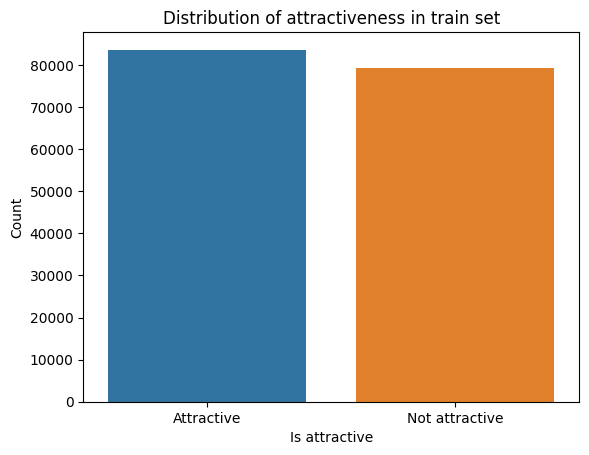

## Models

Since there is categorical data in X, I decided to use the Decision Tree as a reference point.

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

                   precision  recall  f1-score   support

    Not attractive   0.74      0.72      0.73     10064
    Attractive       0.72      0.75      0.73      9898

    accuracy                             0.73     19962
    macro avg        0.73      0.73      0.73     19962
    weighted avg     0.73      0.73      0.73     19962

Okay, so 73% accuracy is the number to beat. 

I chose three models to improve the score:
- Bagging with Decision Tree as base estimator
- Ada boost
- Gradient Boosting

In each of them, the number of estimators is equal to 30.

In [ ]:
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=30)
clf2.fit(X_train, y_train)

In [ ]:
adaboost_model = AdaBoostClassifier(n_estimators=30)
adaboost_model.fit(X_train, y_train)

In [ ]:
grad_model = GradientBoostingClassifier(n_estimators=30)
grad_model.fit(X_train, y_train)

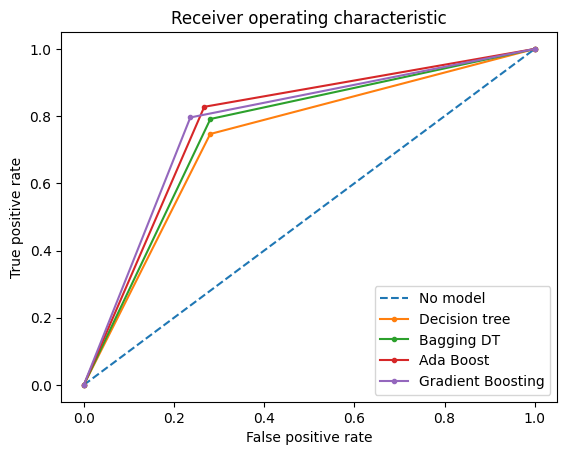

### Exploring the most promising model

Gradient Boosting performed the best so using GridSearchCV I will look for the most optimal parameters for the model

In [ ]:
params = {'n_estimators': [25, 50, 75, 100, 125, 150],  
          'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grad_model = GradientBoostingClassifier()
searcher = GridSearchCV(grad_model, params)
searcher.fit(X_train, y_train)
searcher.best_params_

{'learning_rate': 0.7, 'n_estimators': 100}

In [ ]:
grad_model = GradientBoostingClassifier(learning_rate=0.7, n_estimators=100)
grad_model.fit(X_train, y_train)
y_pred_grab = grad_model.predict(X_test)
print(classification_report(y_test, y_pred_grab))

### Result

                   precision   recall   f1-score  support

    Not attractive   0.82      0.74      0.78     10064
    Attractive       0.76      0.84      0.80      9898

    accuracy                             0.79     19962
    macro avg        0.79      0.79      0.79     19962
    weighted avg     0.79      0.79      0.79     19962

Final result is 79% accuracy

## Predicting based on image

In [ ]:
attributes.columns

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young']
       
       
There are several attributes that define color, for example, columns describing hair color. I'm going to check how strongly these attributes affect the result to decide whether to use color images to train the model.

In [ ]:
attributes.where(df['Blond_Hair']==1).dropna()['Attractive'].value_counts()
attributes.where(df['Gray_Hair']==1).dropna()['Attractive'].value_counts()

Blond hair

     1.0    20932
 
    -1.0     9051

Name: Attractive, dtype: int64



Gray hair

    -1.0    8240

    1.0     259
 
Name: Attractive, dtype: int64

As you can easily observe, hair color has a big impact on the result I am trying to estimate, so I will use color photos to teach the model.

### Loading images and labels divided into training, validation and test sets

In [ ]:
path = r'/content/img_align_celeba/img_align_celeba'
IMG_SIZE = 64

X_train = []
X_test = []
X_val = []
y_train = []
y_test = []
y_val = []


for i in os.listdir(path):
        image = cv2.imread(path + '/' + i)
        image = image.astype('uint8')
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.reshape(IMG_SIZE**2*3)

        if int(lvts.loc[i]) == 0:
            X_train.append(image)
            if int(attributes.loc[i]['Attractive']) == 1:
                y_train.append(int(attributes.loc[i]['Attractive']))
            else:
                y_train.append(0)
        
        if int(lvts.loc[i]) == 1:
            X_val.append(image)
            if int(attributes.loc[i]['Attractive']) == 1:
                y_val.append(int(attributes.loc[i]['Attractive']))
            else:
                y_val.append(0)
        
        if int(lvts.loc[i]) == 2:
            X_test.append(image)
            if int(attributes.loc[i]['Attractive']) == 1:
                y_test.append(int(attributes.loc[i]['Attractive']))
            else:
                y_test.append(0)

### Data preparation

#### X

In [ ]:
X_train= np.array(X_train)
X_test= np.array(X_test)
X_val= np.array(X_val)

X_train= X_train.reshape((len(X_train), IMG_SIZE, IMG_SIZE, 3))
X_test= X_test.reshape((len(X_test), IMG_SIZE, IMG_SIZE, 3))
X_val= X_val.reshape((len(X_val), IMG_SIZE, IMG_SIZE, 3))

X_train= X_train/ 255
X_test= X_test/ 255
X_val= X_val/ 255

#### y

In [ ]:
y_train= np.array(y_train)
y_test= np.array(y_test)
y_val= np.array(y_val)


y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
y_val = y_val.reshape((-1,1))

### Models 

In [ ]:
model = Sequential()

# block 1
model.add(Conv2D(
    32,
    (3, 3),
    activation= 'relu',
    kernel_initializer='he_uniform',
    padding='same',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
))
model.add(BatchNormalization())

# block 2
model.add(Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.2))

# block 3
model.add(Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation= 'relu', kernel_initializer= 'he_uniform' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation= 'sigmoid'))

# compile model
opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=2048,
    validation_data=(X_val, y_val),
    verbose=1
)

As you can see from the chart the firts model has overfittded and achived similar results for the validation set as the Gradient Boosting algorithm on the test set.

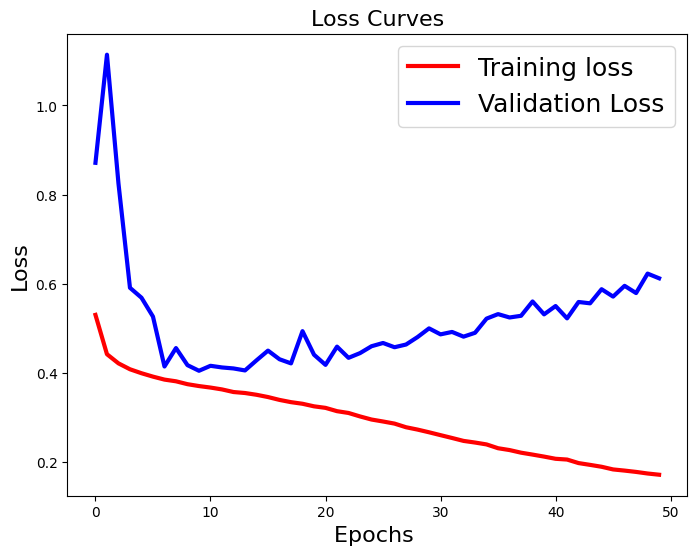

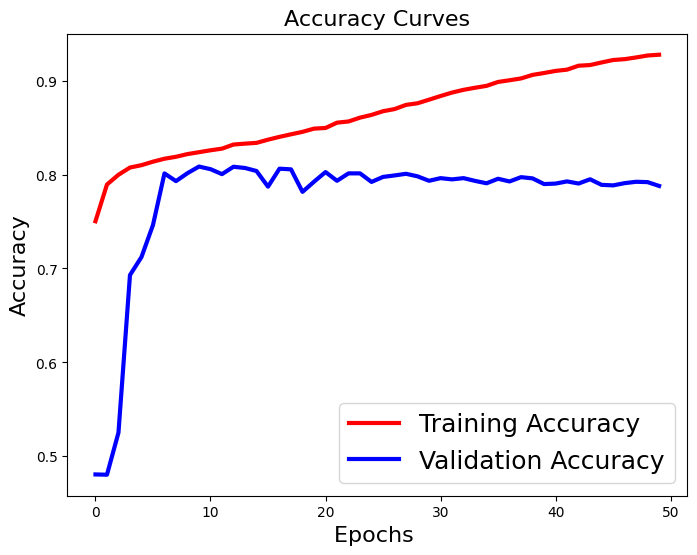

To achieve lerning convergence and improve results, I decided to increase value for dropout to 50% and add another blok of convoltional layers.

In [ ]:
model = Sequential()

# block 1
model.add(Conv2D(
    32,
    (3, 3),
    activation= 'relu',
    kernel_initializer='he_uniform',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
))
model.add(BatchNormalization())

# block 2
model.add(Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.5))

# block 3
model.add(Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.5))

# block 4
model.add(Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_uniform', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D ((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation= 'relu', kernel_initializer= 'he_uniform' ))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation= 'sigmoid'))

# compile model
opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=2048,
    validation_data=(X_val, y_val),
    verbose=1
)

Despite the fact that the accuracy for validation set drops strongly at times, which is due to large dropout value, model does not overfit and achieves nice results.

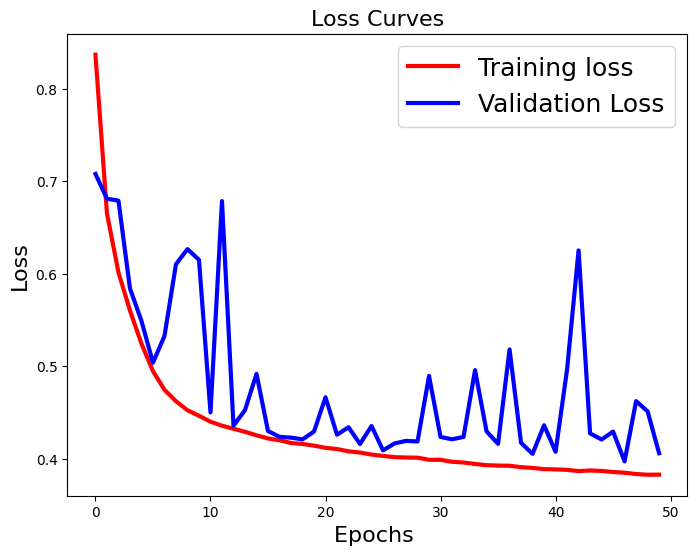

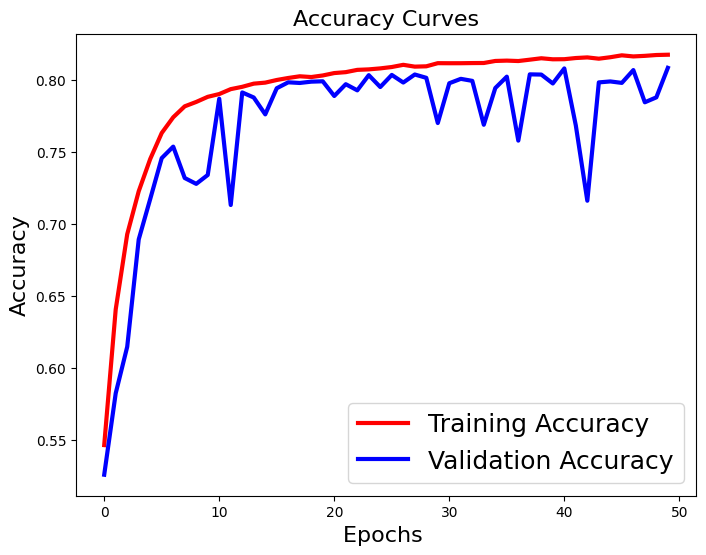

### Result

                   precision   recall  f1-score   support

    Attractive        0.82      0.82      0.82     10064
    Not attractive    0.82      0.81      0.82      9898

    accuracy                              0.82     19962
    macro avg         0.82      0.82      0.82     19962
    weighted avg      0.82      0.82      0.82     19962

## Summary

CNN analyzing images achieves slightly better results than the Gradient Boosting algorithm operating on table data. Depending on business need, we have to choice of two predictive models offering an accuracy of about 80%.

## Postscriptum

It's time to answer a really important question - is Hilary Swank attractive?

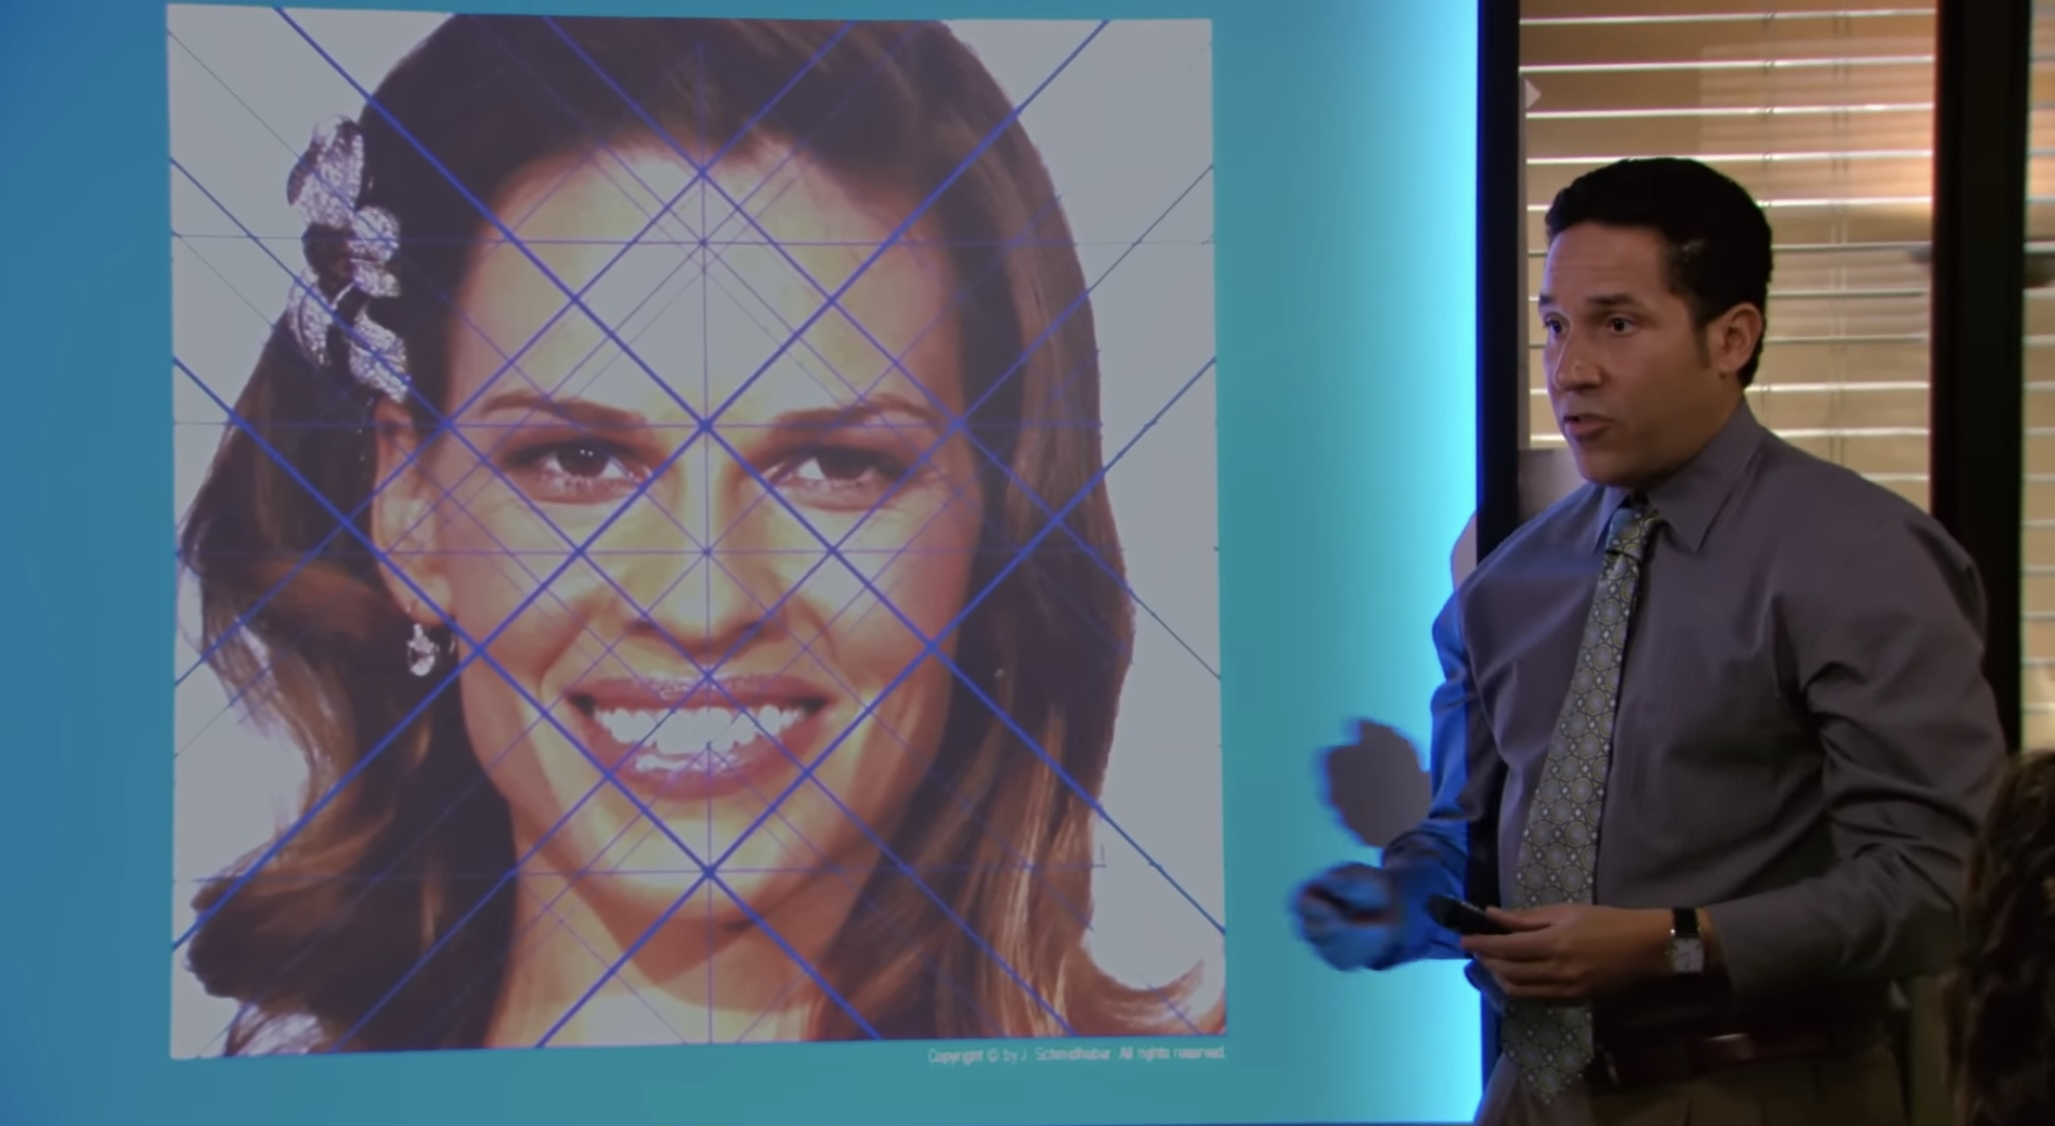

Context: https://www.youtube.com/watch?v=1JAE8kM_Uy4

### Loading images

In [ ]:
hilary = cv2.imread(r'/content/Hilary-Swank.jpg')
hilary = hilary.astype('uint8')
hilary = cv2.resize(hilary, (IMG_SIZE, IMG_SIZE))
hilary = hilary.reshape(IMG_SIZE**2*3)

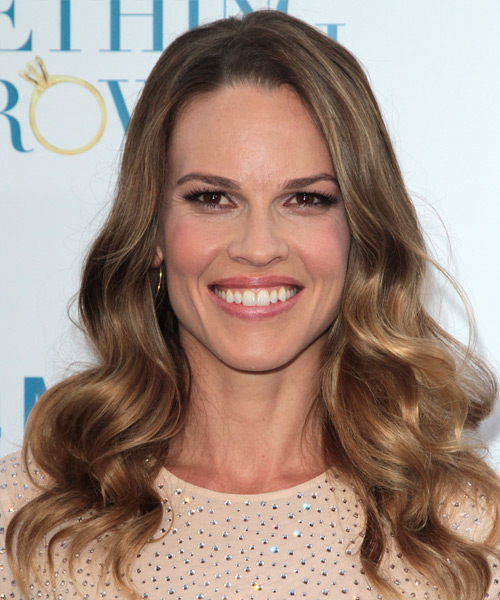

In [ ]:
hilary= np.array(hilary)
hilary= hilary.reshape(1, IMG_SIZE, IMG_SIZE, 3)
hilary= hilary/255

In [ ]:
predictions = model.predict(hilary)
predictions.argmax()

0 ---> She is not attractive 

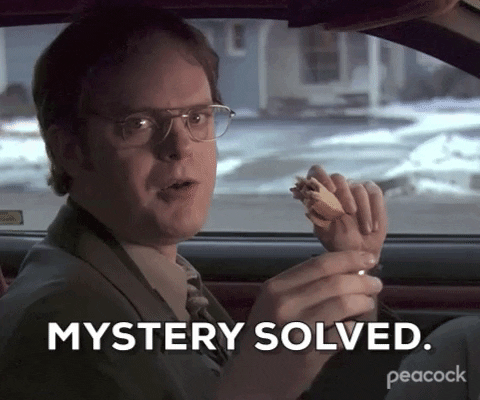